# Comprehensive Network Latency Prediction System

This notebook provides a complete implementation of network latency prediction using both vertical and horizontal partitioning strategies. It includes all data handling, preprocessing, feature engineering, model implementations, and evaluation in a single comprehensive notebook.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Loading and Validation](#data-loading)
3. [Data Preprocessing and Feature Engineering](#preprocessing)
4. [Vertical Partitioning Implementation](#vertical-partitioning)
5. [Horizontal Partitioning Implementation](#horizontal-partitioning)
6. [Model Implementations](#model-implementations)
7. [Comprehensive Evaluation](#evaluation)
8. [Results Analysis and Visualization](#results)
9. [Conclusions and Recommendations](#conclusions)

## 1. Setup and Imports {#setup}

Import all necessary libraries and set up the environment.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment setup completed successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Environment setup completed successfully!
Pandas version: 2.2.3
NumPy version: 2.0.1
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


## 2. Data Loading and Validation {#data-loading}

Load the network latency dataset and perform comprehensive validation.

In [2]:
class ComprehensiveDataLoader:
    """Comprehensive data loader with validation and preprocessing capabilities."""
    
    REQUIRED_COLUMNS = [
        'Tower ID', 'Signal Strength (dBm)', 'Network Traffic (MB)', 
        'Latency (ms)', 'User Count', 'Device Type', 'Location Type'
    ]
    
    def __init__(self):
        self.validation_errors = []
        self.data_summary = {}
    
    def load_and_validate(self, file_path):
        """Load data and perform comprehensive validation."""
        print(f"Loading dataset from: {file_path}")
        
        # Load data
        try:
            df = pd.read_excel(file_path)
            print(f"✓ Successfully loaded {len(df)} rows and {len(df.columns)} columns")
        except Exception as e:
            print(f"✗ Error loading file: {e}")
            return None
        
        # Validate structure
        self._validate_structure(df)
        
        # Generate summary
        self._generate_summary(df)
        
        return df
    
    def _validate_structure(self, df):
        """Validate dataset structure and data quality."""
        self.validation_errors = []
        
        # Check required columns
        missing_cols = set(self.REQUIRED_COLUMNS) - set(df.columns)
        if missing_cols:
            error = f"Missing required columns: {missing_cols}"
            self.validation_errors.append(error)
            print(f"✗ {error}")
        else:
            print("✓ All required columns present")
        
        # Check data types and ranges
        self._validate_columns(df)
        
        # Check for duplicates
        if 'Tower ID' in df.columns:
            duplicates = df['Tower ID'].duplicated().sum()
            if duplicates > 0:
                print(f"⚠ Found {duplicates} duplicate Tower IDs")
            else:
                print("✓ No duplicate Tower IDs")
    
    def _validate_columns(self, df):
        """Validate individual columns."""
        validations = {
            'Signal Strength (dBm)': lambda x: (x >= -150) & (x <= 0),
            'Network Traffic (MB)': lambda x: x >= 0,
            'Latency (ms)': lambda x: x > 0,
            'User Count': lambda x: x >= 0,
            'Location Type': lambda x: x.isin(['Urban', 'Rural', 'Unknown'])
        }
        
        for col, validator in validations.items():
            if col in df.columns:
                valid_mask = validator(df[col].dropna())
                invalid_count = (~valid_mask).sum()
                if invalid_count > 0:
                    print(f"⚠ {col}: {invalid_count} invalid values")
                else:
                    print(f"✓ {col}: All values valid")
    
    def _generate_summary(self, df):
        """Generate comprehensive data summary."""
        self.data_summary = {
            'shape': df.shape,
            'missing_values': df.isnull().sum().to_dict(),
            'data_types': df.dtypes.to_dict()
        }
        
        # Numerical statistics
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            self.data_summary['numeric_stats'] = df[numeric_cols].describe()
        
        # Categorical statistics
        cat_cols = df.select_dtypes(include=['object']).columns
        if len(cat_cols) > 0:
            self.data_summary['categorical_stats'] = {}
            for col in cat_cols:
                self.data_summary['categorical_stats'][col] = df[col].value_counts()

# Initialize data loader
data_loader = ComprehensiveDataLoader()

# Load the dataset
DATA_FILE = 'test_data.xlsx'  # Update this path as needed
raw_data = data_loader.load_and_validate(DATA_FILE)

if raw_data is not None:
    print(f"\nDataset loaded successfully!")
    print(f"Shape: {raw_data.shape}")
    print(f"Columns: {list(raw_data.columns)}")
else:
    print("Failed to load dataset. Please check the file path and format.")

Loading dataset from: test_data.xlsx
✓ Successfully loaded 100 rows and 7 columns
✓ All required columns present
✓ Signal Strength (dBm): All values valid
✓ Network Traffic (MB): All values valid
✓ Latency (ms): All values valid
✓ User Count: All values valid
✓ Location Type: All values valid
✓ No duplicate Tower IDs

Dataset loaded successfully!
Shape: (100, 7)
Columns: ['Tower ID', 'Signal Strength (dBm)', 'Network Traffic (MB)', 'Latency (ms)', 'User Count', 'Device Type', 'Location Type']


### Data Overview and Exploration

In [3]:
if raw_data is not None:
    # Display basic information
    print("=== DATASET OVERVIEW ===")
    print(raw_data.info())
    
    print("\n=== FIRST FEW ROWS ===")
    display(raw_data.head())
    
    print("\n=== MISSING VALUES ===")
    missing_data = raw_data.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) > 0:
        print(missing_data)
    else:
        print("No missing values found!")
    
    print("\n=== NUMERICAL STATISTICS ===")
    display(raw_data.describe())
    
    print("\n=== CATEGORICAL DISTRIBUTIONS ===")
    categorical_cols = ['Device Type', 'Location Type']
    for col in categorical_cols:
        if col in raw_data.columns:
            print(f"\n{col}:")
            print(raw_data[col].value_counts())

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tower ID               100 non-null    object 
 1   Signal Strength (dBm)  99 non-null     float64
 2   Network Traffic (MB)   100 non-null    float64
 3   Latency (ms)           100 non-null    float64
 4   User Count             100 non-null    int64  
 5   Device Type            99 non-null     object 
 6   Location Type          100 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 5.6+ KB
None

=== FIRST FEW ROWS ===


,Tower ID,Signal Strength (dBm),Network Traffic (MB),Latency (ms),User Count,Device Type,Location Type
0,T001,-73.782192,41.114894,131.986013,96,Mobile,Urban
1,T002,-33.449999,640.046307,25.986593,94,Mobile,Rural
2,T003,-48.760424,321.212421,40.709456,47,Desktop,Urban
3,T004,-58.093906,513.484984,180.725296,99,Laptop,Urban
4,T005,-89.078695,908.490809,125.221521,55,Tablet,Rural



=== MISSING VALUES ===
Signal Strength (dBm)    1
Device Type              1
dtype: int64

=== NUMERICAL STATISTICS ===


,Signal Strength (dBm),Network Traffic (MB),Latency (ms),User Count
count,99.000000,100.000000,100.000000,100.000000
mean,-66.865196,502.853406,108.344253,50.380000
std,20.810796,290.180140,55.750987,29.582885
min,-99.613452,16.882609,10.961701,1.000000
25%,-86.185551,249.584481,62.607174,23.750000
50%,-66.944955,510.568609,116.885437,51.000000
75%,-48.843996,768.521762,152.949719,74.500000
max,-30.917914,985.793950,198.110232,99.000000



=== CATEGORICAL DISTRIBUTIONS ===

Device Type:
Device Type
Mobile     33
Desktop    25
Laptop     22
Tablet     19
Name: count, dtype: int64

Location Type:
Location Type
Urban    56
Rural    44
Name: count, dtype: int64


### Data Visualization

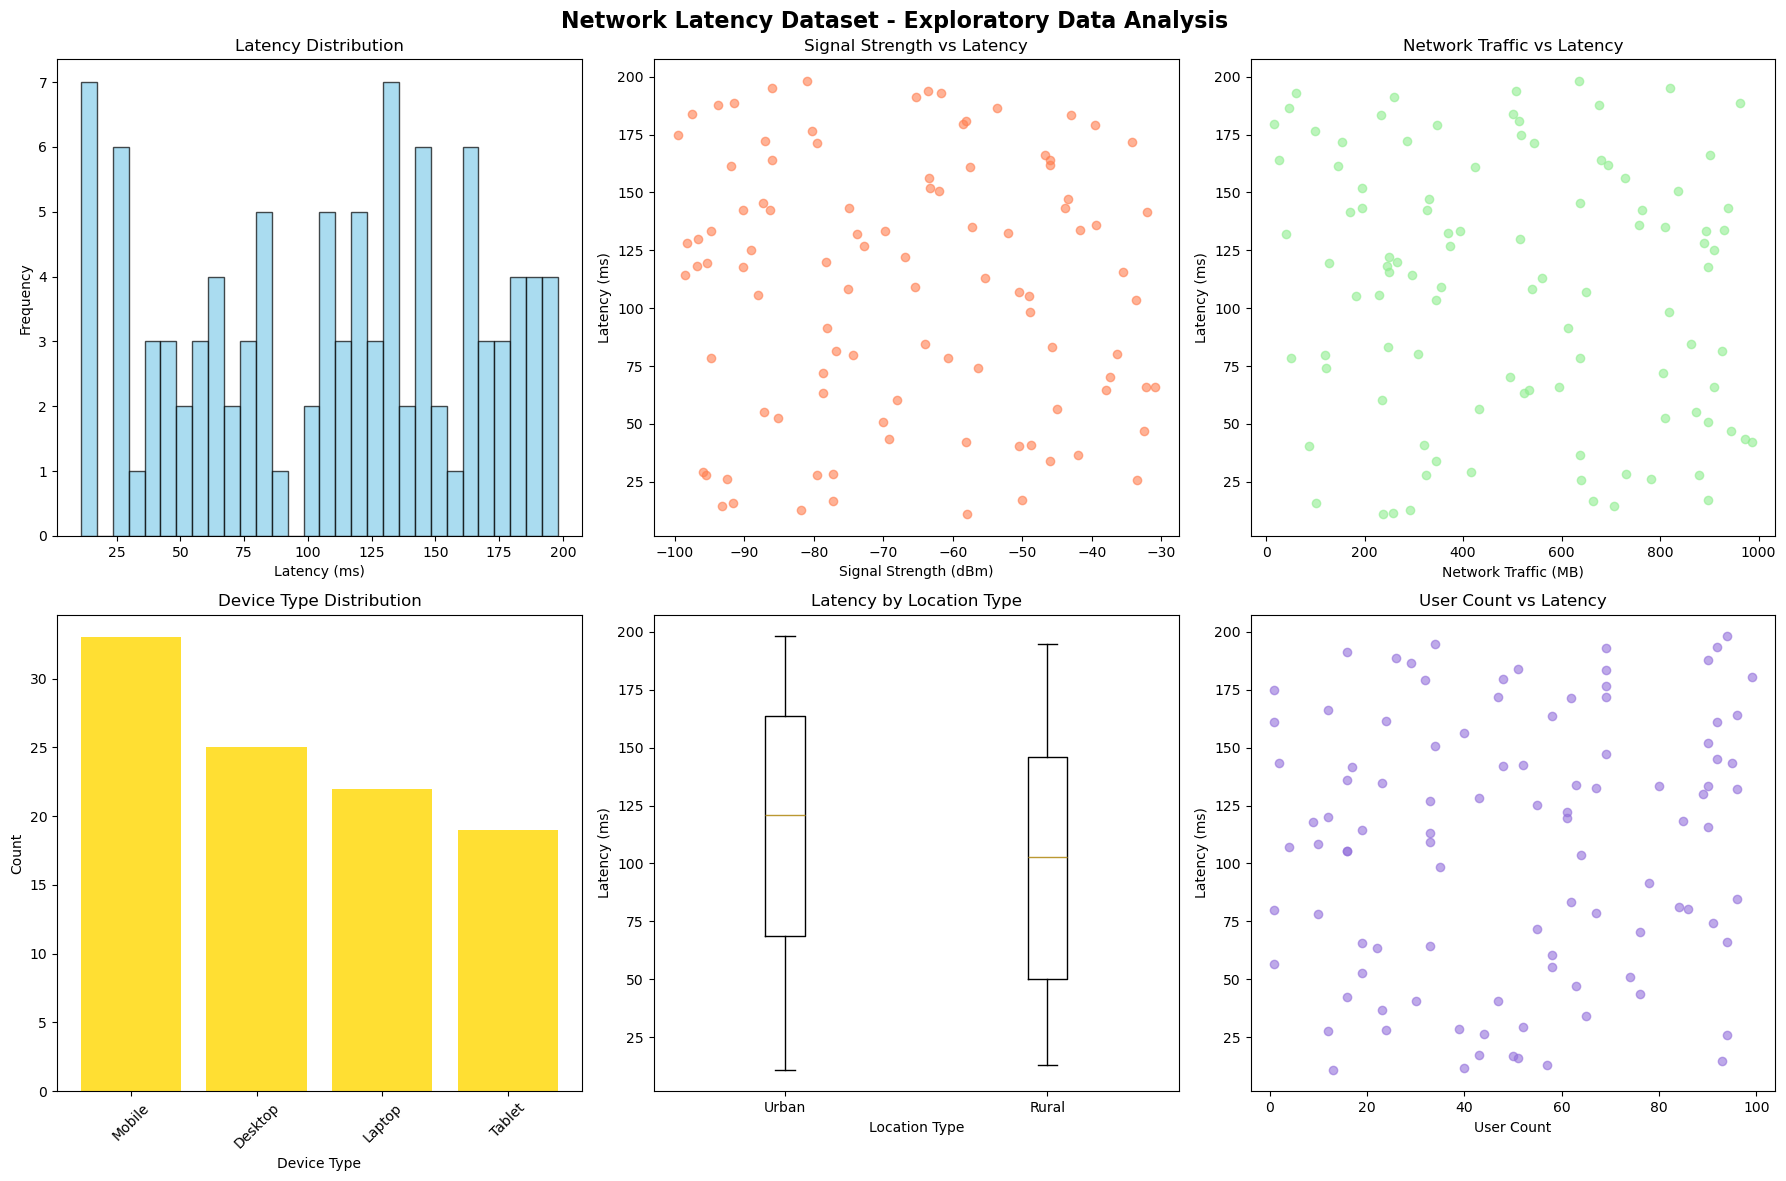

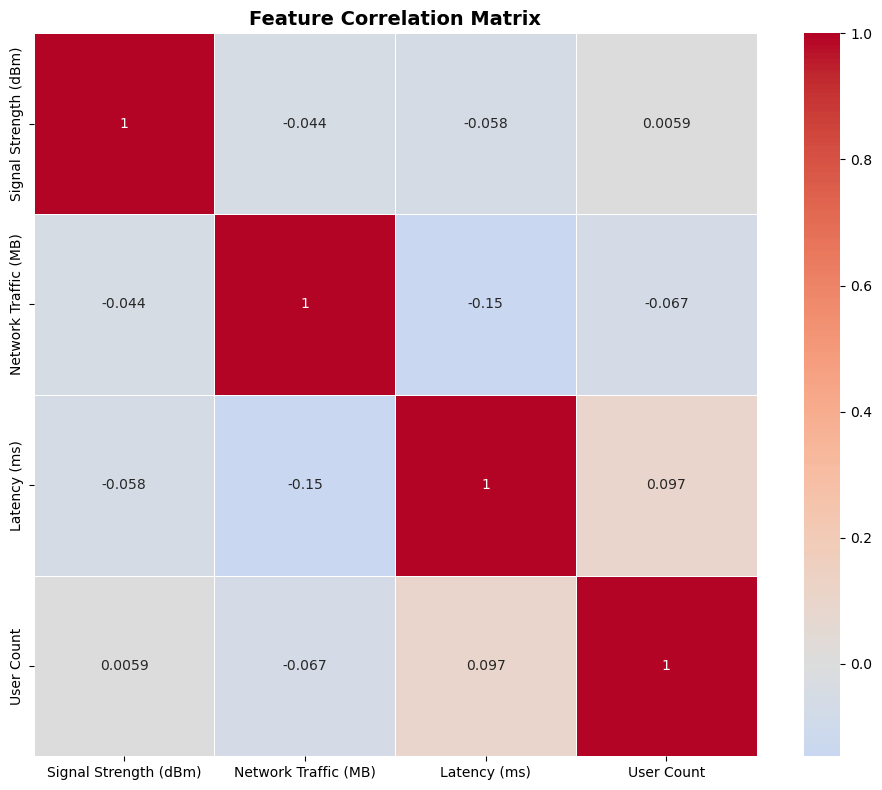

In [4]:
if raw_data is not None:
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Network Latency Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')
    
    # 1. Latency distribution
    axes[0, 0].hist(raw_data['Latency (ms)'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Latency Distribution')
    axes[0, 0].set_xlabel('Latency (ms)')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Signal Strength vs Latency
    axes[0, 1].scatter(raw_data['Signal Strength (dBm)'], raw_data['Latency (ms)'], alpha=0.6, color='coral')
    axes[0, 1].set_title('Signal Strength vs Latency')
    axes[0, 1].set_xlabel('Signal Strength (dBm)')
    axes[0, 1].set_ylabel('Latency (ms)')
    
    # 3. Network Traffic vs Latency
    axes[0, 2].scatter(raw_data['Network Traffic (MB)'], raw_data['Latency (ms)'], alpha=0.6, color='lightgreen')
    axes[0, 2].set_title('Network Traffic vs Latency')
    axes[0, 2].set_xlabel('Network Traffic (MB)')
    axes[0, 2].set_ylabel('Latency (ms)')
    
    # 4. Device Type distribution
    device_counts = raw_data['Device Type'].value_counts()
    axes[1, 0].bar(device_counts.index, device_counts.values, color='gold', alpha=0.8)
    axes[1, 0].set_title('Device Type Distribution')
    axes[1, 0].set_xlabel('Device Type')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 5. Location Type vs Latency
    location_data = [raw_data[raw_data['Location Type'] == loc]['Latency (ms)'].values 
                    for loc in raw_data['Location Type'].unique()]
    axes[1, 1].boxplot(location_data, labels=raw_data['Location Type'].unique())
    axes[1, 1].set_title('Latency by Location Type')
    axes[1, 1].set_xlabel('Location Type')
    axes[1, 1].set_ylabel('Latency (ms)')
    
    # 6. User Count vs Latency
    axes[1, 2].scatter(raw_data['User Count'], raw_data['Latency (ms)'], alpha=0.6, color='mediumpurple')
    axes[1, 2].set_title('User Count vs Latency')
    axes[1, 2].set_xlabel('User Count')
    axes[1, 2].set_ylabel('Latency (ms)')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(10, 8))
    numeric_data = raw_data.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()